# This code creates line plots of one hour median zonal and meridional wind vs UT, for a range of days. Also median in altitude.
## This version adds a curve trend and, dash line to indicate the different storm phases and and arrow that indicates the westward zonal wind.

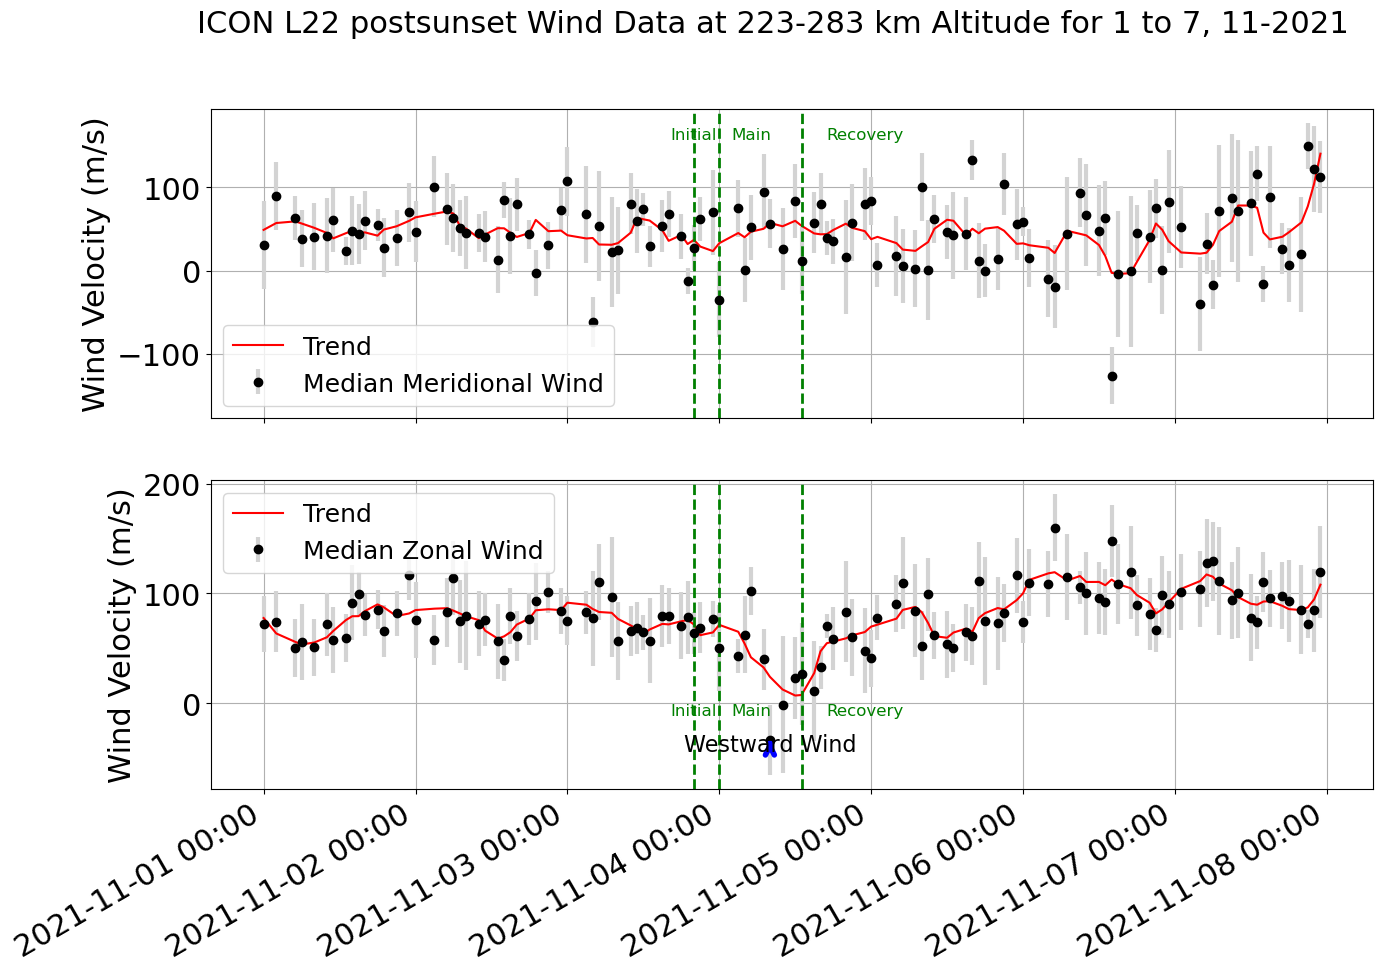

Plot saved as /Users/gildagonzalez/Documents/Articulos-Trabajos/1Gilda/Storms_21/Wind_Nov_21/Wind_Data_223-283km_2021_11.png


In [43]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import pandas as pd
from scipy.signal import savgol_filter

# Set the year, month, day and altitude range
year = 2021
month = 11
altitude_min = 223
altitude_max = 283
start_day = 1   
end_day = 7
custom_filename = f"Wind_Data_{altitude_min}-{altitude_max}km_{year}_{month:02d}.png"

# Initialize lists to store data
all_meridional_wind = []
all_zonal_wind = []
all_utc_time = []
all_local_solar_time = []

# Function to round time to nearest hour
def round_time_to_nearest_hour(time_val):
    return time_val.replace(minute=0, second=0, microsecond=0) + timedelta(hours=time_val.minute//30)

# Loop through each day of the month
for day in range(start_day, end_day + 1):
    pattern = f"/Users/gildagonzalez/Documents/Datos/ICON DATA/MIGHTI/Red line/{year}/icon_l2-2_mighti_vector-wind-red_{year}{month:02d}{day:02d}_v05r*.nc"
    files = glob.glob(pattern)

    if not files:
        print(f"No file found for {year}-{month:02d}-{day:02d}")
        continue

    filename = files[0]

    try:
        with Dataset(filename, 'r') as nc:
            meridional_wind = nc.variables['ICON_L22_Meridional_Wind'][:]
            zonal_wind = nc.variables['ICON_L22_Zonal_Wind'][:]
            utc_time = nc.variables['ICON_L22_UTC_Time'][:]
            local_solar_time = nc.variables['ICON_L22_Local_Solar_Time'][:]
            altitude = nc.variables['ICON_L22_Altitude'][:]
            wind_quality = nc.variables['ICON_L22_Wind_Quality'][:]

            utc_time = [datetime.strptime(time, "%Y-%m-%d %H:%M:%S.%fZ") for time in utc_time]

            lst_min = 19
            lst_max = 22
            altitude_tolerance = 1

            valid_data = local_solar_time < 1e36
            filter_indices = np.where((local_solar_time >= lst_min) &
                                      (local_solar_time <= lst_max) &
                                      (wind_quality == 1) &
                                      (altitude >= altitude_min) &
                                      (altitude <= altitude_max) &
                                      valid_data)
            
            all_meridional_wind.extend(meridional_wind[filter_indices])
            all_zonal_wind.extend(zonal_wind[filter_indices])
            all_utc_time.extend(np.array(utc_time)[filter_indices[0]])
            all_local_solar_time.extend(local_solar_time[filter_indices])

    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

# Function to aggregate data by hour using median
def aggregate_by_hour_median(utc_times, winds):
    unique_hours = np.unique([round_time_to_nearest_hour(t) for t in utc_times])
    median_winds = []
    std_winds = []

    for hour in unique_hours:
        hour_winds = [winds[i] for i, t in enumerate(utc_times) if round_time_to_nearest_hour(t) == hour]
        median_winds.append(np.median(hour_winds))
        std_winds.append(np.std(hour_winds))

    return unique_hours, np.array(median_winds), np.array(std_winds)

# Convert lists to numpy arrays and sort by UTC time for aggregation
all_utc_time = np.array(all_utc_time)
sort_indices = np.argsort(all_utc_time)
all_meridional_wind = np.array(all_meridional_wind)[sort_indices]
all_zonal_wind = np.array(all_zonal_wind)[sort_indices]
all_utc_time_sorted = all_utc_time[sort_indices]

# Aggregate meridional and zonal wind data using median
hours, median_meridional_wind, std_meridional_wind = aggregate_by_hour_median(all_utc_time_sorted, all_meridional_wind)
_, median_zonal_wind, std_zonal_wind = aggregate_by_hour_median(all_utc_time_sorted, all_zonal_wind)

# Apply Savitzky-Golay filter to obtain the trend curves
meridional_trend = savgol_filter(median_meridional_wind, 11, 3)
zonal_trend = savgol_filter(median_zonal_wind, 11, 3)

# Plotting the wind data
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Customize colors and line styles
meridional_color = 'black'
zonal_color = 'black'
line_style = '-'

# Plotting Meridional Wind with Error Bars
axs[0].errorbar(hours, median_meridional_wind, yerr=std_meridional_wind, fmt='o', color=meridional_color, ecolor='lightgray', elinewidth=3, capsize=0, label='Median Meridional Wind')
axs[0].plot(hours, meridional_trend, color='red', linestyle=line_style, label='Trend')
axs[0].set_ylabel('Wind Speed (m/s)', color=meridional_color)
axs[0].tick_params(axis='y', labelcolor=meridional_color)
axs[0].grid(True)
axs[0].legend()

# Plotting Zonal Wind with Error Bars
axs[1].errorbar(hours, median_zonal_wind, yerr=std_zonal_wind, fmt='o', color=zonal_color, ecolor='lightgray', elinewidth=3, capsize=0, label='Median Zonal Wind')
axs[1].plot(hours, zonal_trend, color='red', linestyle=line_style, label='Trend')
axs[1].set_ylabel('Wind Speed (m/s)', color=zonal_color)
axs[1].tick_params(axis='y', labelcolor=zonal_color)
axs[1].grid(True)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
axs[1].legend()
plt.gcf().autofmt_xdate()

# Indicating the point where the zonal wind is "most westward"
min_zonal_wind_idx = hours[np.argmin(median_zonal_wind)]
min_zonal_wind_value = median_zonal_wind.min()
axs[1].annotate('Westward Wind', xy=(min_zonal_wind_idx, min_zonal_wind_value), 
                xytext=(min_zonal_wind_idx, min_zonal_wind_value - 15),
                arrowprops=dict(color='blue', arrowstyle='->', shrinkA=0, shrinkB=10, 
                                linewidth=4, linestyle='-', alpha=1),
                fontsize=16, ha='center', va='bottom')

# Adding vertical dashed lines to indicate the storm phases
initial_phase_start = "2021-11-03 20:00"
initial_phase_end = "2021-11-04 00:00"
main_phase_end = "2021-11-04 13:00"

axs[0].axvline(pd.to_datetime(initial_phase_start), color='green', linestyle='--', linewidth=2)
axs[0].axvline(pd.to_datetime(initial_phase_end), color='green', linestyle='--', linewidth=2)
axs[0].axvline(pd.to_datetime(main_phase_end), color='green', linestyle='--', linewidth=2)

axs[1].axvline(pd.to_datetime(initial_phase_start), color='green', linestyle='--', linewidth=2)
axs[1].axvline(pd.to_datetime(initial_phase_end), color='green', linestyle='--', linewidth=2)
axs[1].axvline(pd.to_datetime(main_phase_end), color='green', linestyle='--', linewidth=2)

# Adding text annotations for storm phases in both plots
text_properties = dict(color='green', fontsize=12, ha='center', va='bottom')

# Separate horizontal offsets for text annotations (in hours)
initial_phase_offset = 0
main_phase_offset = 5
recovery_phase_offset = 10

# Text for Meridional Wind Plot
axs[0].text(pd.to_datetime(initial_phase_start) + timedelta(hours=initial_phase_offset), np.max(median_meridional_wind) + 5, "Initial", **text_properties)
axs[0].text(pd.to_datetime(initial_phase_end) + timedelta(hours=main_phase_offset), np.max(median_meridional_wind) + 5, "Main", **text_properties)
axs[0].text(pd.to_datetime(main_phase_end) + timedelta(hours=recovery_phase_offset), np.max(median_meridional_wind) + 5, "Recovery", **text_properties)

# Text for Zonal Wind Plot
axs[1].text(pd.to_datetime(initial_phase_start) + timedelta(hours=initial_phase_offset), min_zonal_wind_value + 20, "Initial", **text_properties)
axs[1].text(pd.to_datetime(initial_phase_end) + timedelta(hours=main_phase_offset), min_zonal_wind_value + 20, "Main", **text_properties)
axs[1].text(pd.to_datetime(main_phase_end) + timedelta(hours=recovery_phase_offset), min_zonal_wind_value + 20, "Recovery", **text_properties)

# Customizations (titles, labels, etc.)
title_fontsize = 22
label_fontsize = 22
ticks_fontsize = 22
legend_fontsize = 18

fig.suptitle(f'ICON L22 postsunset Wind Data at {altitude_min}-{altitude_max} km Altitude for 1 to 7, {month:02d}-{year}', fontsize=title_fontsize)
axs[0].set_ylabel('Wind Velocity (m/s)', color=meridional_color, fontsize=label_fontsize)
axs[1].set_ylabel('Wind Velocity (m/s)', color=zonal_color, fontsize=label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=ticks_fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=ticks_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[1].legend(fontsize=legend_fontsize)

# Save and display the figure
output_directory = "/Users/gildagonzalez/Documents/Articulos-Trabajos/1Gilda/Storms_21/Wind_Nov_21"
os.makedirs(output_directory, exist_ok=True)
output_path = os.path.join(output_directory, custom_filename)
plt.savefig(output_path, dpi=300)

show_plot = True
if show_plot:
    plt.show()
else:
    plt.close()

print(f"Plot saved as {output_path}")
